# **HW1: Regression**

In _assignment 1_, you need to finish:

1.  Basic Part: Implement the regression model to predict the number of dengue cases

> - Step 1: Split Data
> - Step 2: Preprocess Data
> - Step 3: Implement Regression
> - Step 4: Make Prediction
> - Step 5: Train Model and Generate Result

2.  Advanced Part: Implementing a regression model to predict the number of dengue cases in a different way than the basic part


# 1. Basic Part (60%)

In the first part, you need to implement the regression to predict the number of dengue cases

Please save the prediction result in a csv file **hw1_basic.csv**


## Import Packages

> Note: You **cannot** import any other package in the basic part


In [513]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import math
import random


## Global attributes

Define the global attributes


In [514]:
# Input file named as 'hw1_basic_input.csv'
input_dataroot = 'hw1_basic_input.csv'
# Output file will be named as 'hw1_basic.csv'
output_dataroot = 'hw1_basic.csv'

# Initial datalist, saved as numpy array
input_datalist = []
# Your prediction, should be 10 * 4 matrix and saved as numpy array
output_datalist = []
# The format of each row should be ['epiweek', 'CityA', 'CityB', 'CityC']

train_dataset = []
validation_dataset = []
toPredict_dataset = []
models = []

MatrixInversion = "MatrixInversion"
FastGradientDescent = "FastGradientDescent"
GradientDescent = "GradientDescent"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(linewidth=100000)


You can add your own global attributes here


In [515]:
output_weeks = 10
train_all = True
validation_weeks = 10
preprocess_data = True
preprocess_all_columns = True
drop_unwanted = False

## data
input_ratio = [1, 0.6, 0.5]

## auto regression
orders = [2, 3, 3]

previous_weeks = [2, 2, 2]
lagging_weeks = [0, 0, 0]
order_per_weeks = [1, 1, 1]

fitting_method = GradientDescent
target_models = [0, 1, 2]

## gradient descent
learning_rate = 5e-2
loss_precision = 1e-6
epochs = 500000
lmbd = [5e-2, 5e-3, 5e-3]

In [516]:
def calc_mape(pred_Y, Y):
    mape = np.mean(np.absolute((Y - pred_Y) / Y), dtype=np.float64) * 100
    return mape


def get_xy(input_data, x_idx):
    ret_x = []
    for i in range(3):
        X = input_data[i][previous_weeks[i]:, [i+ii for ii in x_idx]]
        for o in range(2, orders[i]+1, 1):
            X = np.hstack((X, np.float_power(
                input_data[i][previous_weeks[i]:, [i+ii for ii in x_idx]], o)))
        if (previous_weeks[i]):
            # for d in range(previous_weeks[i]):
            for d in range(previous_weeks[i]-lagging_weeks[i]):
                for o in range(order_per_weeks[i]):
                    X = np.hstack(
                        (X, np.float_power(input_data[i][d:-previous_weeks[i]+d, [i+4]], o+1)))
        ret_x.append(X)
    ret_y = [input_data[i][previous_weeks[i]:, [i+4]] for i in range(3)]
    return (ret_x, ret_y)


class auto_regression_model:
    def __init__(self, previous_weeks, lagging_weeks, order_per_weeks):
        self.w = None
        self.previous_weeks = previous_weeks
        self.lagging_weeks = lagging_weeks
        self.order_per_weeks = order_per_weeks

    def fit(self, X, Y, method=MatrixInversion, epochs=10000, lr=5e-2, lmbd=0):
        m, n = X.shape
        self.M = X.mean(axis=0)
        self.S = X.max(axis=0) - X.min(axis=0)

        if (method == MatrixInversion):
            ''' w = ((phi^T)*(phi))^-1 * phi^T * y '''
            X = self.normalize(X)
            X = np.hstack((np.ones((m, 1)), X))
            self.w = np.linalg.lstsq(X, Y, rcond=None)[0]

        elif (method == FastGradientDescent):
            X = self.normalize(X)
            X = np.hstack((np.ones((m, 1)), X))

            epoch = 0
            prev_loss = 100
            loss = 0
            while (epoch < epochs and abs(prev_loss - loss) > loss_precision):
                if (epoch == 0):
                    self.w = np.random.rand(n+1, 1)
                pred_Y = X.dot(self.w)
                diff_y = Y - pred_Y
                g = 2 * np.mean(diff_y * X, axis=0).reshape(-1, 1) - lmbd / m * 2 * self.w
                self.w = self.w + lr * g
                prev_loss = loss
                loss = calc_mape(pred_Y, Y)
                if (epoch % 10 == 0):
                    print(
                        f"epoch={epoch}, loss={loss}, loss diff={abs(prev_loss-loss)}", end="\r")
                epoch += 1
            print()

        elif (method == GradientDescent):
            loc_X = X.copy()
            pred_Y = Y.copy()

            epoch = 0
            prev_loss = 100
            loss = 0
            while (epoch < epochs and abs(prev_loss - loss) > loss_precision):
            # while (epoch < epochs and (abs(prev_loss - loss) > loss_precision or prev_loss - loss < 0)):
                if (epoch == 0):
                    self.w = np.random.rand(n+1, 1)

                for r in range(m):
                    row_X = loc_X[[r]]
                    yy = self.get_y(row_X)[0, 0]
                    pred_Y[[r], 0] = yy
                    for d in range(min(m-r-1, self.previous_weeks), self.lagging_weeks, -1):
                        for o in range(self.order_per_weeks):
                            loc_X[r+d, (-d+self.lagging_weeks) *
                                  self.order_per_weeks+o] = np.float_power(yy, o+1)

                diff_y = Y - pred_Y
                g = 2 * np.mean(diff_y * np.hstack(
                    (np.ones((X.shape[0], 1)), self.normalize(loc_X))), axis=0).reshape(-1, 1) - lmbd / m * 2 * self.w
                self.w = self.w + lr * g
                prev_loss = loss
                loss = calc_mape(pred_Y, Y)
                if (epoch % 10 == 0):
                    print(
                        f"epoch={epoch}, loss={loss}, loss diff={abs(prev_loss-loss)}", end="\r")
                epoch += 1
            print()

    def predict(self, X: np.ndarray):
        m, n = X.shape
        X = X.copy()
        pred_Y = np.ndarray((m, 1))
        for r in range(m):
            row_X = X[[r]]
            yy = self.get_y(row_X)[0, 0]
            pred_Y[[r], 0] = yy
            for d in range(min(m-r-1, self.previous_weeks), self.lagging_weeks, -1):
                for o in range(self.order_per_weeks):
                    X[r+d, (-d+self.lagging_weeks) *
                      self.order_per_weeks+o] = np.float_power(yy, o+1)
        return pred_Y

    def get_y(self, X: np.ndarray):
        X = self.normalize(X)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return X.dot(self.w)
    
    def normalize(self, X: np.ndarray):
        return (X - self.M) / self.S

    def get_model(self):
        return self.w


## Load the Input File

First, load the basic input file **hw1_basic_input.csv**

Input data would be stored in _input_datalist_


In [517]:
# Read input csv to datalist
with open(input_dataroot, newline='') as csvfile:
    input_datalist = np.array(list(csv.reader(csvfile)))


## Implement the Regression Model

> Note: It is recommended to use the functions we defined, you can also define your own functions


### Step 0: Preprocess


In [518]:
def PreprocessDatalist(datalist, x_idx=[1, 2, 3]):
    df = pd.DataFrame(datalist)
    df = df.iloc[1:]
    df = df.replace('', np.nan).astype(np.float64)

    if preprocess_data:
        udf = df[:-output_weeks]
        Q1 = udf.quantile(0.25)
        Q3 = udf.quantile(0.75)
        IQR = Q3 - Q1
        ldf = udf < (Q1 - 1.5 * IQR)
        rdf = udf > (Q3 + 1.5 * IQR)
        if (preprocess_all_columns):
            df[(ldf | rdf)] = np.nan
        else:
            mask = pd.DataFrame(index=df.index, columns=df.columns, dtype=bool, data=False)
            mask.iloc[:,x_idx] = True
            df[(ldf | rdf) & mask] = np.nan

    if (drop_unwanted):
        df = df.dropna()
    else:
        df = df.interpolate()
        df = df.fillna(method="ffill")
        df = df.fillna(method="bfill")

    datalist = df.to_numpy()
    return datalist


### Step 1: Split Data

Split data in _input_datalist_ into training dataset and validation dataset


In [519]:
def SplitData(datalist):
    print("Spliting Data...")

    train = []
    validation = []
    toPredict = [datalist[-output_weeks-previous_weeks[i]:] for i in range(3)]
    datalist = datalist[:-output_weeks]

    input_weeks = [int(datalist.shape[0] * input_ratio[i]) for i in range(3)]
    datalist = [datalist[-input_weeks[i]:] for i in range(3)]
    print(f"data weeks: {input_weeks}")

    # train_weeks = [int(datalist[i].shape[0] * (1 - validation_ratio)) for i in range(3)]
    train_weeks = [int(datalist[i].shape[0] - validation_weeks) for i in range(3)]
    train = []
    if (train_all):
        train = datalist
    else:
        train = [datalist[i][:train_weeks[i]] for i in range(3)]
    validation = [datalist[i][train_weeks[i]-previous_weeks[i]:]
                  for i in range(3)]

    return (train, validation, toPredict)


### Step 2: Preprocess Data

Handle the unreasonable data

> Hint: Outlier and missing data can be handled by removing the data or adding the values with the help of statistics


In [520]:
def PreprocessData():
    return


### Step 3: Implement Regression

> Hint: You can use Matrix Inversion, or Gradient Descent to finish this part


In [521]:
def Regression(models, train, validation, lmbd, x_idx: list = [1], target_models=[0, 1, 2]):
    train_x, train_y = get_xy(train, x_idx)
    validation_x, validation_y = get_xy(validation, x_idx)

    mape_sum = 0
    for i in target_models:
        X, Y = train_x[i], train_y[i]
        print(f"Model {chr(i+65)} training...")
        models[i].fit(X, Y, method=fitting_method,
                      epochs=epochs, lr=learning_rate, lmbd=lmbd[i])

    try:
        for i in target_models:
            X, Y = validation_x[i], validation_y[i]
            pred_y = models[i].predict(X)
            mape = calc_mape(pred_y, Y)
            mape_sum += mape
            print(f"MAPE {chr(i+65)}: {mape}%")

        print(f"Average MAPE: {mape_sum / len(target_models)}%")
    except:
        pass

    return


In [522]:
def PlotModels(models, train, validation, x_idx: list = [1], target_models=[0,1,2]):
    train_x, train_y = get_xy(train, x_idx)
    validation_x, validation_y = get_xy(validation, x_idx)

    # for i in target_models:
        # plt.subplot(231)
        # plt.title("train: y truth")
        # plt.plot(train_y[i])
        # plt.subplot(232)
        # plt.title("train: x dot w")
        # plt.plot(models[i].get_y(train_x[i]))
        # plt.subplot(233)
        # plt.title("train: predict(x)")
        # plt.plot(models[i].predict(train_x[i]))
        # plt.subplot(234)
        # plt.title("validation: y truth")
        # plt.plot(validation_y[i])
        # plt.subplot(235)
        # plt.title("validation: x dot w")
        # plt.plot(models[i].get_y(validation_x[i]))
        # plt.subplot(236)
        # plt.title("validation: predict(x)")
        # plt.plot(models[i].predict(validation_x[i]))
        # plt.show()

    for i in target_models:
        plt.subplot(221)
        plt.title("train: y truth")
        plt.plot(train_y[i])
        plt.subplot(222)
        plt.title("train: predict(x)")
        plt.plot(models[i].predict(train_x[i]))
        plt.subplot(223)
        plt.title("validation: y truth")
        plt.plot(validation_y[i])
        plt.subplot(224)
        plt.title("validation: predict(x)")
        plt.plot(models[i].predict(validation_x[i]))
        plt.show()
    return

### Step 4: Make Prediction

Make prediction of testing dataset and store the value in _output_datalist_


In [523]:
def MakePrediction(models, toPredict, x_idx: list = [1]):
    def f(result):
        result[result < 0] = 0
        result = np.round(result).astype(np.int64)
        return result

    toPredict_x, toPredict_y = get_xy(toPredict, x_idx)
    output_datalist = toPredict[0][-output_weeks:, [0]].astype(np.int64)

    for i in range(len(models)):
        result = f(models[i].predict(toPredict_x[i]))
        output_datalist = np.hstack((output_datalist, result))

    return output_datalist


### Step 5: Train Model and Generate Result

> Notice: **Remember to output the coefficients of the model here**, otherwise 5 points would be deducted

- If your regression model is _3x^2 + 2x^1 + 1_, your output would be:

```
3 2 1
```


In [524]:
# %%capture cap_basic --no-stderr
input_datalist = PreprocessDatalist(input_datalist)
train_dataset, validation_dataset, toPredict_dataset = SplitData(
    input_datalist)
models = [auto_regression_model(
    previous_weeks[i], lagging_weeks[i], order_per_weeks[i]) for i in range(3)]
print(f"Regression Method: {fitting_method}")
Regression(models, train_dataset, validation_dataset, lmbd, target_models=target_models)
if(len(target_models) == 3):
    output_datalist = MakePrediction(models, toPredict_dataset)

print("orders:", orders)
print("validation weeks:", validation_weeks)
print("previous weeks:", previous_weeks)
print("lagging weeks:", lagging_weeks)
print("orders per weeks:", order_per_weeks)

for i in target_models:
    print(f"Model {chr(i+65)}:")
    print(f"coef: {models[i].get_model().reshape(-1)}")
    print(f"mean: {models[i].M}")
    print(f"max - min: {models[i].S}")


Spliting Data...
data weeks: [94, 56, 47]
Regression Method: GradientDescent
Model A training...
epoch=1780, loss=26.976317273461493, loss diff=1.0970003465615719e-06
Model B training...
epoch=49210, loss=14.114466894540904, loss diff=3.09426093636489e-0666
Model C training...
epoch=102020, loss=21.9712055162692, loss diff=1.000031051745509e-06066
MAPE A: 17.492764483801242%
MAPE B: 16.89882345658883%
MAPE C: 14.127360049329413%
Average MAPE: 16.172982663239825%
orders: [2, 3, 3]
validation weeks: 10
previous weeks: [2, 2, 2]
lagging weeks: [0, 0, 0]
orders per weeks: [1, 1, 1]
Model A:
coef: [ 50.47233537 -10.50476585  -8.01546565  40.75167135  27.78636102]
mean: [ 25.27978261 644.8663188   52.0326087   51.22826087]
max - min: [ 11.84   567.6096  77.      77.    ]
Model B:
coef: [ 23.0178891   13.75776876   0.8163419  -14.21628792  -1.27137836  19.36810357]
mean: [   22.98824074   530.29591528 12275.00378483    23.51851852    23.16666667]
max - min: [6.84000000e+00 3.07389600e+02 1.04

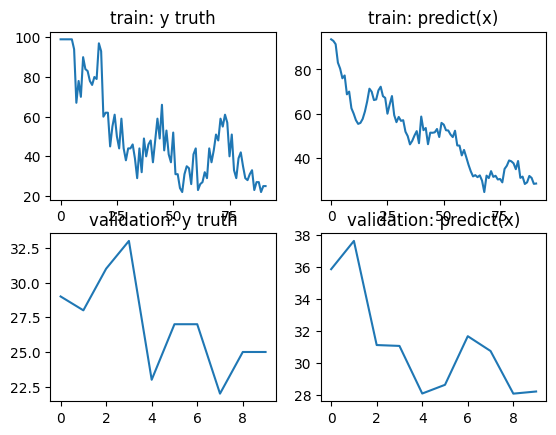

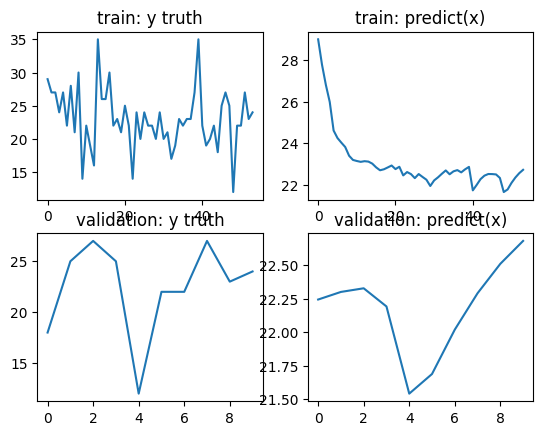

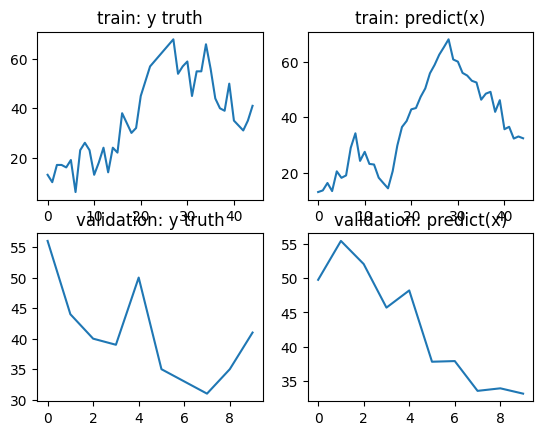

In [525]:
PlotModels(models, train_dataset, validation_dataset, target_models=target_models)

## Write the Output File

Write the prediction to output csv

> Format: 'epiweek', 'CityA', 'CityB', 'CityC'


In [526]:
with open(output_dataroot, 'w', newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for row in output_datalist:
        writer.writerow(row)


# 2. Advanced Part (35%)

In the second part, you need to implement the regression in a different way than the basic part to help your predictions for the number of dengue cases

We provide you with two files **hw1_advanced_input1.csv** and **hw1_advanced_input2.csv** that can help you in this part

Please save the prediction result in a csv file **hw1_advanced.csv**


## Attributes


In [527]:
advanced_input_dataroot = 'hw1_basic_input.csv'
advanced_input1_dataroot = 'hw1_advanced_input1.csv'
advanced_input2_dataroot = 'hw1_advanced_input2.csv'
advanced_output_dataroot = 'hw1_advanced.csv'

advanced_input_datalist = []
advanced_input1_datalist = []
advanced_input2_datalist = []
advanced_output_datalist = []

train_dataset = []
validation_dataset = []
toPredict_dataset = []


## Load Files


In [528]:
# Read input csv to datalist
with open(advanced_input_dataroot, newline='') as csvfile:
    advanced_input_datalist = np.array(list(csv.reader(csvfile)))

with open(advanced_input1_dataroot, newline='') as csvfile:
    advanced_input1_datalist = np.array(list(csv.reader(csvfile)))

with open(advanced_input2_dataroot, newline='') as csvfile:
    advanced_input2_datalist = np.array(list(csv.reader(csvfile)))


### Implementation


In [529]:
## data
input_ratio = [1, 0.6, 0.5]

## auto regression
orders = [3, 1, 3]

previous_weeks = [2, 2, 2]
lagging_weeks = [0, 0, 0]
order_per_weeks = [1, 1, 1]

fitting_method = GradientDescent
# target_models = [2]

## gradient descent
# learning_rate = 5e-2
# loss_precision = 1e-6
# epochs = 50000
# lmbd = [5e-1, 5e-2, 5e-3]

In [530]:
# %%capture cap_advanced --no-stderr
advanced_input_datalist = np.hstack(
    (advanced_input_datalist, advanced_input1_datalist[:, 1:]))
advanced_input_datalist = PreprocessDatalist(
    advanced_input_datalist, x_idx=[1, 2, 3])
train_dataset, validation_dataset, toPredict_dataset = SplitData(
    advanced_input_datalist)
advanced_models = [auto_regression_model(
    previous_weeks[i], lagging_weeks[i], order_per_weeks[i]) for i in range(3)]
Regression(advanced_models, train_dataset, validation_dataset, lmbd, x_idx=[1, 7], target_models=target_models)
if(len(target_models) == 3):
    advanced_output_datalist = MakePrediction(
        advanced_models, toPredict_dataset, x_idx=[1, 7])

print("orders:", orders)
print("validation weeks:", validation_weeks)
print("previous weeks:", previous_weeks)
print("lagging weeks:", lagging_weeks)
print("orders per weeks:", order_per_weeks)

for i in target_models:
    print(f"Model {chr(i+65)}:")
    print(f"coef: {advanced_models[i].get_model().reshape(-1)}")
    print(f"mean: {advanced_models[i].M}")
    print(f"max - min: {advanced_models[i].S}")


Spliting Data...
data weeks: [94, 56, 47]
Model A training...
epoch=950, loss=24.549704836821, loss diff=3.981542915099112e-057117
Model B training...
epoch=5830, loss=14.438740924944197, loss diff=1.006734178687907e-066
Model C training...
epoch=114600, loss=16.51571738586904, loss diff=9.999784076342166e-0766
MAPE A: 12.178195103940116%
MAPE B: 17.42551394702524%
MAPE C: 16.40734456820731%
Average MAPE: 15.337017873057556%
orders: [3, 1, 3]
validation weeks: 10
previous weeks: [2, 2, 2]
lagging weeks: [0, 0, 0]
orders per weeks: [1, 1, 1]
Model A:
coef: [50.3934751  -5.18746629 -0.6563513  -4.58851281  2.88007518 -3.37036428  3.28204865 41.95013913 28.80724111]
mean: [2.52797826e+01 4.44983696e+00 6.44866319e+02 3.10171796e+01 1.65851881e+04 2.64486110e+02 5.20326087e+01 5.12282609e+01]
max - min: [1.18400000e+01 1.36600000e+01 5.67609600e+02 1.86595600e+02 2.08233525e+04 2.54889590e+03 7.70000000e+01 7.70000000e+01]
Model B:
coef: [23.01942248 -0.45209011 -0.62125772 11.77193664  0.

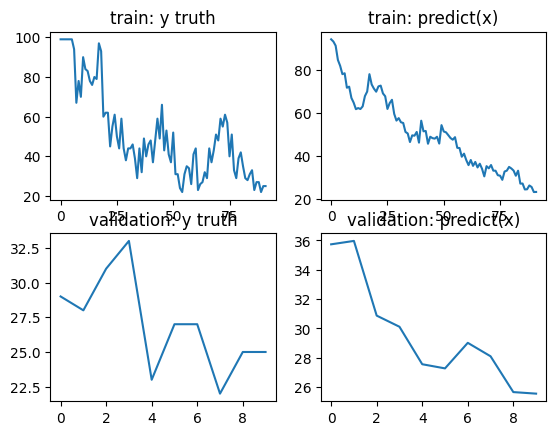

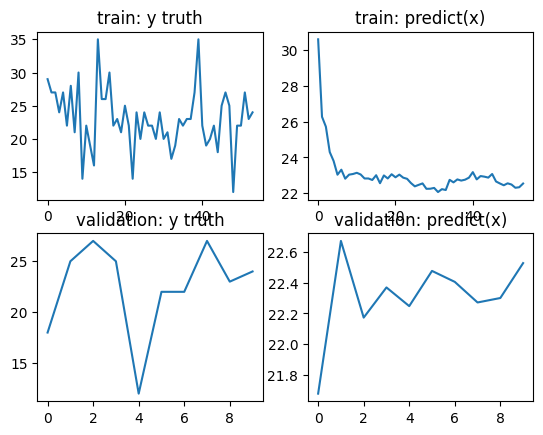

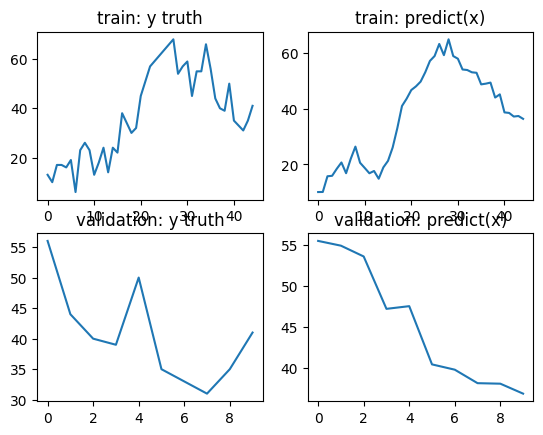

In [531]:
PlotModels(advanced_models, train_dataset, validation_dataset, x_idx=[1, 7], target_models=target_models)

## Write Ouptut File


In [532]:
with open(advanced_output_dataroot, 'w', newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for row in advanced_output_datalist:
        writer.writerow(row)


# Report _(5%)_

Report should be submitted as a pdf file **hw1_report.pdf**

- Briefly describe the difficulty you encountered
- Summarize your work and your reflections
- No more than one page


# Save the Code File

Please save your code and submit it as an ipynb file! (**hw1.ipynb**)


In [533]:
# with open('output.txt', 'w') as f:
#     f.write(cap_basic.stdout)
#     f.write(cap_advanced.stdout)